# Lab14-2 GAN
110065508 李丞恩

本次的Lab是要實作Improved WGAN，並在CelebA資料集上訓練，以生成"不存在的人臉"。

In [1]:
SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 200
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUFFER_SIZE = 20000

W_LR = 1e-4
W_EPOCH = 256

ITEMS_PER_FILE = 2000

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import re
from pprint import pprint
from tqdm.notebook import tqdm
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

2021-12-22 03:43:50.866336: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], \
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

2021-12-22 03:43:51.858890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-22 03:43:51.890466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 03:43:51.890933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-22 03:43:51.890951: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-22 03:43:51.892681: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-22 03:43:51.892715: I tensorflow/stream_executor/pl

In [5]:
if not os.path.exists("input") : os.mkdir("input")
if not os.path.exists("output") : os.mkdir("output")
if not os.path.exists("output/gif") : os.mkdir("output/gif")
if not os.path.exists("output/imgs_HW") : os.mkdir("output/imgs_HW")
if not os.path.exists("output/imgs_not_HW") : os.mkdir("output/imgs_not_HW")

## 一. 製作CelebA的tfrecord檔
由於這次的dataset十分大，記憶體一定塞不下，因此我認為使用tfrecord讀取檔案為當。我是使用Linux系統，將dataset下載下來後，首先使用

$ sudo apt install p7zip-full

下載7zip的壓縮程式，接著滑鼠右鍵手動解一次壓縮，接著使用

\$ for z in *.7z.*; do 7z e "\$ z"; done

解完所有壓縮檔，接著用

$ rm -i img_align_celeba_png.7z.*

刪掉所有解好的壓縮檔，避免浪費空間。

### 1. Write tfrecords
首先讀取所有file的路徑存到all_image_paths之中。

In [6]:
data_root = pathlib.Path('./input/datalab-lab-14-2')
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = [path for path in all_image_paths if path[-3:] in ('png')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)


total img num: 202599


接著定義寫入tfrecord所需的函式，這部分參考了Lab12-1的code，以及一些github上的資料。我發現如果一次把所有檔案寫到同一個tfrecord裡，model會train不起來，讀取也會有問題，因此設定每2000筆data寫到一個tfrecod中。

In [8]:
def load_img(img_name):
    raw_img = tf.io.read_file('./' + img_name)
    return raw_img

def _bytes_feature(value): # Returns a bytes_list from a string / byte.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def to_tfrecord(img):  
    feature = {
        'img': _bytes_feature(img)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def tf_serialize_example(img):
    tf_string = tf.py_function(
        to_tfrecord,
        [img],
        tf.string)
    return tf.reshape(tf_string, ())

def prepare_tfrecords(all_image_paths):
    num = 0
    for i in range(0, len(all_image_paths), ITEMS_PER_FILE):
        raw_image_data = tf.data.Dataset.from_tensor_slices(all_image_paths[i:i+ITEMS_PER_FILE])
        raw_image_data = raw_image_data.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        serialized_features_dataset = raw_image_data.map( \
            tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        filename = f'./input/tfrecord/train_{num:03d}_.tfrecord'
        writer = tf.data.experimental.TFRecordWriter(filename)
        writer.write(serialized_features_dataset)
        num+=1

在指定的資料夾中生成tfrecord。

In [9]:
# prepare_tfrecords(all_image_paths) # 跑過一次就不要再跑了

### 2. preprocess the data
利用與Lab12-1類似的方式定義讀取圖片的方式。

In [10]:
def processing(raw_img):
    img = tf.image.decode_png(raw_img, channels=3)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img,tf.float32)
    img = img / 255.
    return img

In [11]:
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    return parsed['img']

### 3. Read dataset
先直接讀取所有tfrecord。

In [12]:
data_root = pathlib.Path('./input/tfrecord')
filename_list = list(data_root.glob('*'))
filename_list = [str(path) for path in filename_list]
filename_list = [path for path in filename_list if path[-8:] in ('tfrecord')]
tfrecord_count = len(filename_list)
print('\ntotal tfrecord num:', tfrecord_count)


total tfrecord num: 102


In [13]:
raw_dataset_train = tf.data.TFRecordDataset(filename_list)

2021-12-22 03:43:52.601028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 03:43:52.601472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 03:43:52.601985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-22 03:43:52.602059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative va

接著按照定義的方式讀取檔案，要注意的是一定要drop_remainder，否則將會因會最後一個batch裝不滿，導致訓練時出現錯誤！

In [14]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)
dsTrain = parsed_dataset_train.map(processing)
dsTrain = dsTrain.shuffle(BUFFER_SIZE)
dsTrain = dsTrain.batch(BATCH_SIZE,drop_remainder=True)
dsTrain = dsTrain.prefetch(500)

## 二. 設計GAN的架構
這裡要定義Generator以及Discriminator兩個神經網路的架構。我決定直接沿用課程網頁給的架構。

In [15]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

根據improved WGAN的演算法，必須使用Adam作為優化器，並將$\beta_1$設為0，$\beta_2$設為0.9。

In [16]:
IWG, IWD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(W_LR, beta_1=0, beta_2=0.9)
optimizer_d = keras.optimizers.Adam(W_LR, beta_1=0, beta_2=0.9)

## 三. GAN的訓練函數定義
這部分實作較為簡單，按照sudo code去實作就可以了。要注意的是各種參數(如$x$，$\tilde{x}$等)不要傳錯。

In [17]:
@tf.function
def IWGTrain(c1):
    z = tf.random.normal(BZ) # sample latent variable z form p(z), I don't know why but just keep it out
    with tf.GradientTape() as tpg:
        with tf.GradientTape() as tp_gradientpenalty:
            x = c1 # sample x from \mathbb{P}_r
            epsilon = np.random.uniform(0, 1) # sample \epsilon from U[0,1]
            
            x_tilde = IWG(z, training = True) # \tilde{x}<-G_\theta(z)
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)
            
            Dwx_tilde = IWD(x_tilde, training = True)
            Dwx = IWD(x, training = True)
            grad = IWD(x_hat, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_gradientpenalty.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty
            
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)
        
    gradient_g = tpg.gradient(lg, IWG.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, IWG.trainable_variables))
    return lg, ld

@tf.function
def IWDTrain(c1):
    z = tf.random.normal(BZ) # sample latent variable z form p(z), I don't know why but just keep it out
    with tf.GradientTape() as tpd:
        with tf.GradientTape() as tp_gradientpenalty:
            x = c1 # sample x from \mathbb{P}_r
            epsilon = np.random.uniform(0, 1) # sample \epsilon from U[0,1]
            
            x_tilde = IWG(z, training = True) # \tilde{x}<-G_\theta(z)
            x_hat = tf.math.scalar_mul(epsilon, x) + tf.math.scalar_mul((1 - epsilon), x_tilde)
            
            Dwx_tilde = IWD(x_tilde, training = True)
            Dwx = IWD(x, training = True)
            grad = IWD(x_hat, training = True)
            penalty = 10 * tf.math.square(tf.norm(tp_gradientpenalty.gradient(grad, x_hat), ord='euclidean') - 1)
            loss = Dwx_tilde - Dwx + penalty
            
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(Dwx_tilde)
        
    gradient_d = tpd.gradient(ld, IWD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, IWD.trainable_variables))
    return lg, ld

我猜也要用5:1去做。

In [18]:
# ratio of training step D:G = 5:1
WTrain = (
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWDTrain,
    IWGTrain
)

WCritic = len(WTrain)

## 四. 訓練過程視覺化

In [19]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

開始訓練$\sim$燃燒吧我的GPU$\sim$

  0%|          | 0/256 [00:00<?, ?it/s]

2021-12-22 03:43:53.431964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-22 03:43:53.456283: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz
2021-12-22 03:43:57.846794: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-22 03:43:58.785493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-12-22 03:43:59.911972: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-22 03:43:59.912006: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2021-12-22 03:43:59.912709: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-22 03:43:59.912767: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

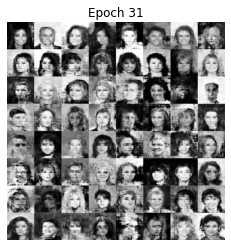

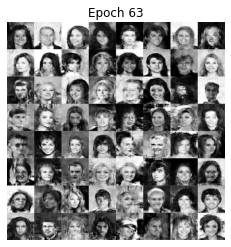

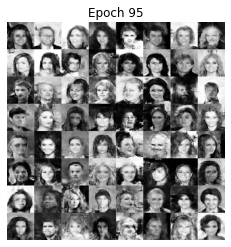

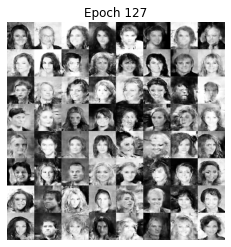

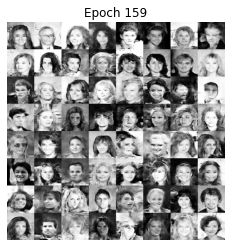

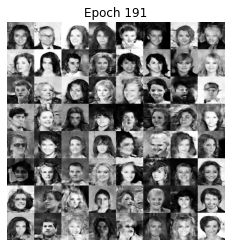

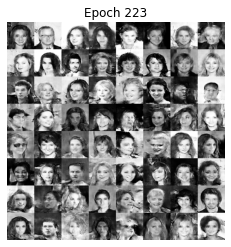

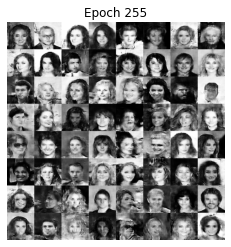

In [20]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(image_count)
ctr = 0
for ep in tqdm(range(W_EPOCH)):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = IWG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./output/imgs_HW/iw_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

將GIF檔儲存。由於我的notebook無法正常顯示，我會另外附上gif檔交上去。

In [21]:
utMakeGif(np.array(wsp), "./output/gif/improved_wgan_celebA_110065508.gif", duration = 2)

MoviePy - Building file ./output/gif/improved_wgan_celebA_110065508.gif with imageio.


繪製loss的圖形，可以發現在5個epoch以內，improved WGAN就已經學到人臉的流形，以至於training loss收斂了。

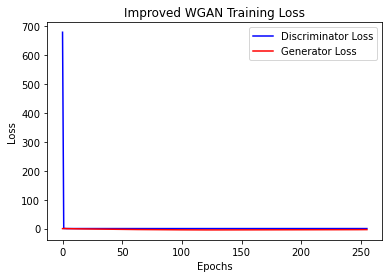

In [22]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved WGAN Training Loss")
plt.show()

## 五. 成果展示

寫一個從GAN所生成的$8\times8$的馬賽克拼圖中展示$64\times 64$大小人臉的函式。

In [40]:
def show_img(row, col, path):
    generated_picture = plt.imread(path)
    picture = generated_picture[row*IMG_H:(row+1)*IMG_H, col*IMG_W:(col+1)*IMG_W, :]
    plt.imshow(picture)
    plt.axis("off")
    plt.show()

取最後一個epoch中所生成的圖片來看，這位女士竟然長出了墨鏡！我有點訝異GAN連這個都能學得到。

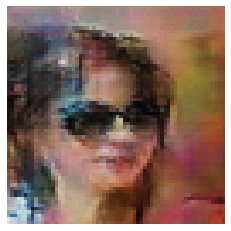

In [43]:
show_img(4, 0,'output/imgs_HW/iw_0255.png')

這是一位有山羊鬍的先生，髮型長得很像國泰世華的logo，滿好笑的。

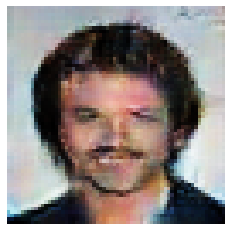

In [44]:
show_img(6, 7,'output/imgs_HW/iw_0255.png')

這次的lab很有趣也很實用，我從國中開始就有蒐集LoveLive的圖片，迄今應該已經蒐集了5萬張左右，希望寒假時可以把這個lab拿來生成學園偶像。接著把成果放到P站上，實現不會畫圖也能當繪師的夢想XD